## Workshop 12 - Titanic with Deep Learning

In [36]:
# Import Library
from IPython.display import clear_output

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import scikitplot as skplt
import matplotlib.pyplot as plt

In [37]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [38]:
# load dataset
df = pd.read_csv("titanic-train.csv")


In [39]:
df2 = df.loc[:,['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]
df2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


In [40]:
print('Age missing ', df2['Age'].isnull().sum())
print('PClass missing ', df2['Pclass'].isnull().sum())
print('SibSp missing ', df2['SibSp'].isnull().sum())
print('Parch missing ', df2['Parch'].isnull().sum())
print('Survived missing ', df2['Survived'].isnull().sum())

Age missing  177
PClass missing  0
SibSp missing  0
Parch missing  0
Survived missing  0


In [41]:
df2['Age'] = df2['Age'].fillna(df2['Age'].mean())

print('Age missing ', df2['Age'].isnull().sum())

Age missing  0


In [42]:
df3 = pd.get_dummies(df2)
df3.head()

,Survived,Pclass,Age,SibSp,Parch,Sex_female,Sex_male
0,0,3,22.0,1,0,0,1
1,1,1,38.0,1,0,1,0
2,1,3,26.0,0,0,1,0
3,1,1,35.0,1,0,1,0
4,0,3,35.0,0,0,0,1


In [43]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df3[['Pclass','Sex_female','Sex_male','Age','SibSp','Parch']], 
                                                    df3['Survived'], 
                                                    train_size=0.7, 
                                                    random_state=123)
print("Labels for training and testing data")
train_X.head()

Labels for training and testing data


/Users/kris/anaconda3/anaconda/envs/softwarepark/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,Pclass,Sex_female,Sex_male,Age,SibSp,Parch
416,2,1,0,34.0,1,1
801,2,1,0,31.0,1,1
512,1,0,1,36.0,0,0
455,3,0,1,29.0,0,0
757,2,0,1,18.0,0,0


## Define Neural Network

6 inputs -> [8 hidden nodes] -> [4 hidden nodes] -> outputs

In [44]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [45]:
def create_model(optimizer='adam', init='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=train_X.shape[1], kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(4, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scaling
train_X = scaler.fit_transform(train_X)
test_X = scale.fit_transform(test_X)


train_X = train_X.astype(float)
test_x = test_X.astype(float)


/Users/kris/anaconda3/anaconda/envs/softwarepark/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kris/anaconda3/anaconda/envs/softwarepark/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/kris/anaconda3/anaconda/envs/softwarepark/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kris/anaconda3/anaconda/envs/softwarepark/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  re

In [56]:
# Create a classifier with best parameters
model_pred = KerasClassifier(build_fn=create_model, 
                             optimizer='adam', 
                             epochs=300, 
                             batch_size=30, verbose=0)



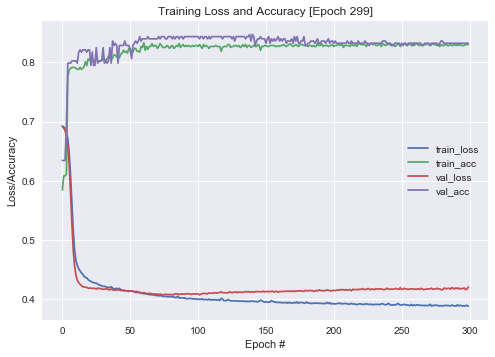

In [57]:
model_pred.fit(train_X, 
               train_y,
                validation_data=(test_X, test_y),
                callbacks=[plot_losses])


In [58]:

# Predict 'Survived'
prediction = model_pred.predict(test_X)

In [59]:

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [60]:
from sklearn.metrics import accuracy_score
print("Predicting survival on the test set")

print("Accurary : ", round(accuracy_score(test_y, prediction),4))
print(classification_report(test_y, prediction))
print(confusion_matrix(test_y, prediction))


Predicting survival on the test set
Accurary :  0.8321
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       170
           1       0.79      0.73      0.76        98

   micro avg       0.83      0.83      0.83       268
   macro avg       0.82      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268

[[151  19]
 [ 26  72]]


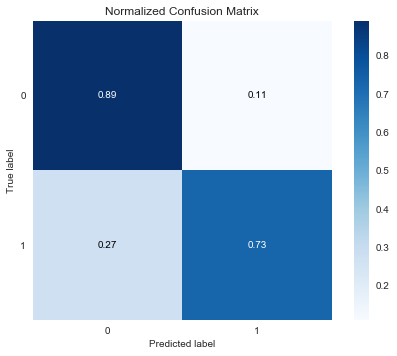

In [61]:


skplt.metrics.plot_confusion_matrix(test_y, prediction, normalize=True)
plt.show()

In [62]:
from sklearn.metrics import roc_auc_score
# calculate AUC
auc = roc_auc_score(test_y, prediction)
print('AUC: %.3f' % auc)

AUC: 0.811
